<a href="https://colab.research.google.com/github/bot5294/AL_ML_21_days_21_projects/blob/main/Day_13/Aqib's_13th_Assignment_stock_price_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction (NIFTY50)

Using ML and DL to predict NIFTY50 stock prices.


Data used: https://www.kaggle.com/datasets/ashishjangra27/nifty-50-25-yrs-data

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from copy import deepcopy

from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


Data prep

In [ ]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns =  ['High']
day_chunks =  [30, 60, 90]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

Defining the models

In [ ]:
def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

Defining the ML/DL models

In [ ]:
ml_models = [
    ("KNN", KNeighborsRegressor())
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

Model training:

In [ ]:
trained_models = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Model stats

In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_High_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_High_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,RNN_High_30,"<Sequential name=sequential, built=True>",6387.125164,8841.015511,5890.066868,8444.603069
6,RNN_High_60,"<Sequential name=sequential_4, built=True>",6419.643512,8878.641929,5964.174860,8381.204583
11,RNN_High_90,"<Sequential name=sequential_8, built=True>",6434.212768,8882.155580,6156.738079,8599.179378
4,Bidirectional_LSTM_High_30,"<Sequential name=sequential_3, built=True>",7038.610204,9428.545980,6519.401917,9011.393111
8,GRU_High_60,"<Sequential name=sequential_6, built=True>",7024.793438,9429.811487,6543.436641,8922.131508
3,GRU_High_30,"<Sequential name=sequential_2, built=True>",7127.160890,9494.850883,6607.975709,9075.678896
14,Bidirectional_LSTM_High_90,"<Sequential name=sequential_11, built=True>",6981.300138,9388.414752,6681.589928,9098.153242


In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_High_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_High_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,RNN_High_30,"<Sequential name=sequential, built=True>",6387.125164,8841.015511,5890.066868,8444.603069
6,RNN_High_60,"<Sequential name=sequential_4, built=True>",6419.643512,8878.641929,5964.174860,8381.204583
11,RNN_High_90,"<Sequential name=sequential_8, built=True>",6434.212768,8882.155580,6156.738079,8599.179378
4,Bidirectional_LSTM_High_30,"<Sequential name=sequential_3, built=True>",7038.610204,9428.545980,6519.401917,9011.393111
8,GRU_High_60,"<Sequential name=sequential_6, built=True>",7024.793438,9429.811487,6543.436641,8922.131508
3,GRU_High_30,"<Sequential name=sequential_2, built=True>",7127.160890,9494.850883,6607.975709,9075.678896
14,Bidirectional_LSTM_High_90,"<Sequential name=sequential_11, built=True>",6981.300138,9388.414752,6681.589928,9098.153242


Comparing the models

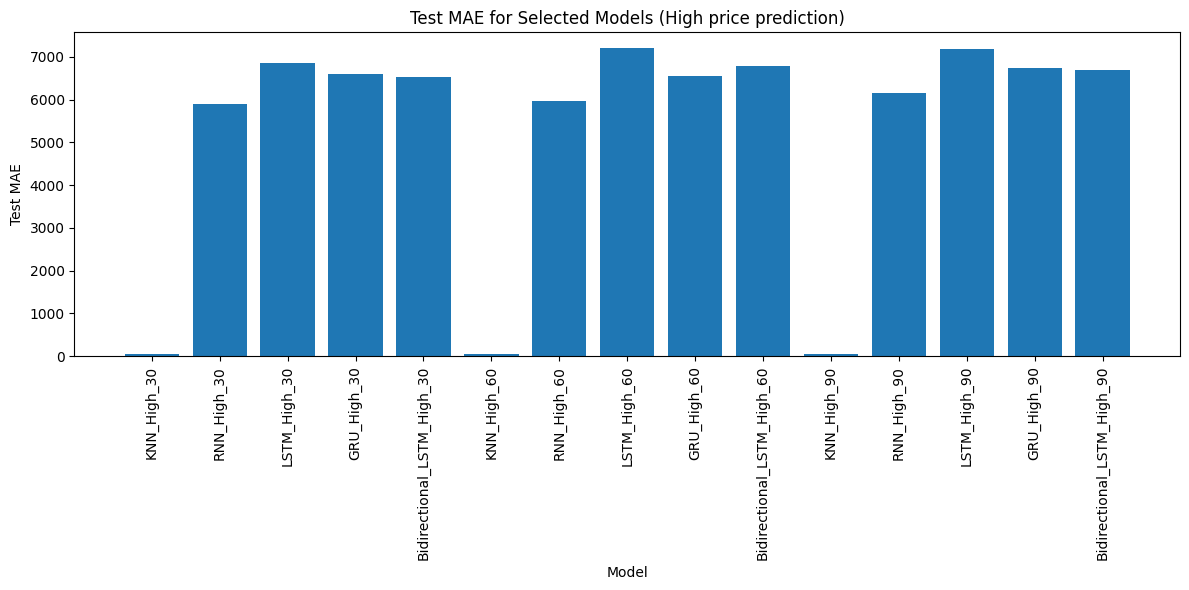

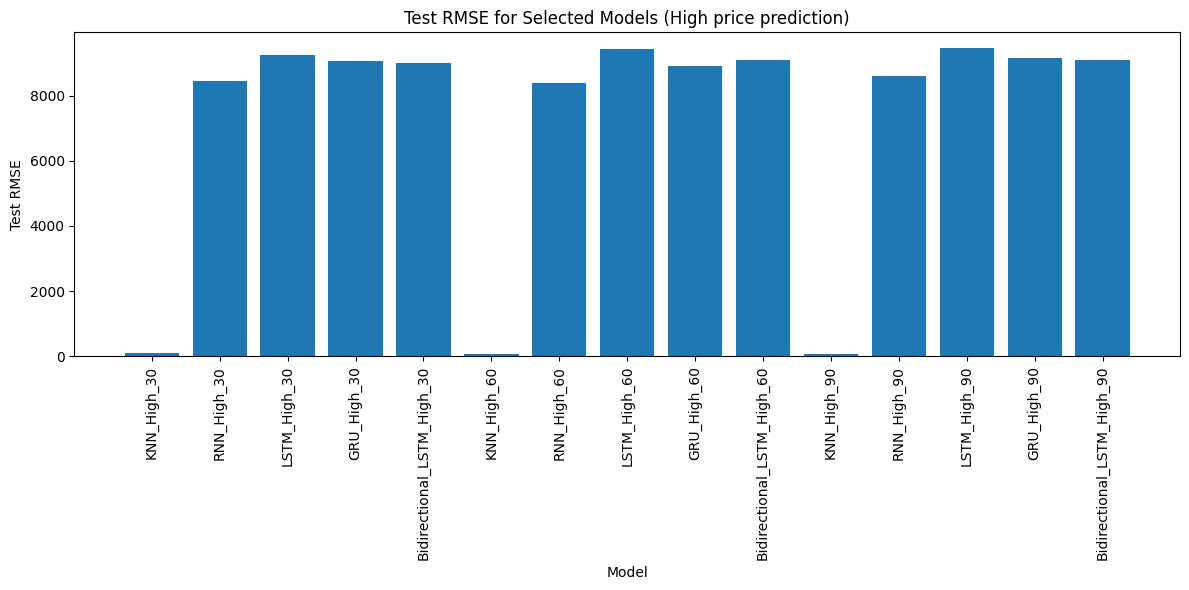

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['test_mae'])
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Test MAE')
plt.title('Test MAE for Selected Models (High price prediction)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['test_rmse'])
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Test RMSE')
plt.title('Test RMSE for Selected Models (High price prediction)')
plt.tight_layout()
plt.show()